In [1]:
import gym
import numpy as np

import sys
import matplotlib.pyplot as plt

import dual_sourcing
import utility

import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple

- add max inventory to dual_sourcing
- 

In [3]:
# CONFIG = {'Lr': 2, 'Le': 1, 'cr': 100, 'ce': 105, 'lambda': 2,
#           'h': 1, 'b': 19, 'starting_state': [0]*4, 'max_order': 4, 'max_inventory': 10}

CONFIG = {'Lr': 5, 'Le': 1, 'cr': 100, 'ce': 105, 'lambda': 10,
          'h': 1, 'b': 19, 'starting_state': [0]*7, 'max_order': 20, 'max_inventory': 1000}

env = gym.make('DualSourcing-v0', config=CONFIG)
# env = DualSourcing(CONFIG)
env.seed(0)

0

In [5]:
# Share the parameters

state_space = env.observation_space.shape[0]
action_space = (env.max_order+1) ** 2

#Hyperparameters
gamma = 0.99
render = False
eps = np.finfo(np.float32).eps.item()
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# hidden size = 32
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_space, 32)

        self.action_head = nn.Linear(32, action_space)
        self.value_head = nn.Linear(32, 1) # Scalar Value

        self.save_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_score = self.action_head(x)
        state_value = self.value_head(x)

        return F.softmax(action_score, dim=-1), state_value

In [6]:
torch.manual_seed(0)
learning_rate = 0.01
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# for name, layer in model.named_modules(): ###regular gradient
#         if type(layer) == nn.Linear:
#             print(layer.weight.data)
#             print(layer.bias.data)

def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.save_actions.append(SavedAction(m.log_prob(action), state_value))

    return action.item()

In [7]:
def finish_episode():
    R = 0
    save_actions = model.save_actions
    policy_loss = []
    value_loss = []
    rewards = []

    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)

    rewards = torch.tensor(rewards)
#     rewards = (rewards - rewards.mean()) / (rewards.std() + eps)

    for (log_prob , value), r in zip(save_actions, rewards):
        reward = r - value.item()
        policy_loss.append(-log_prob * reward)
#         value_loss.append(F.l1_loss(value, torch.tensor([r])))
        value_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))
#         value_loss.append(F.mse_loss(value, torch.tensor([r])))

    optimizer.zero_grad()
    loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()
    loss.backward()
    optimizer.step()

    del model.rewards[:]
    del model.save_actions[:]

In [8]:
def TBS(env, r, S):
    ip = np.sum(env.state[1:(env.Le+1)]) + np.sum(env.state[env.Lr:])
    return r, max(0, S-ip)

In [10]:
m = env.max_order + 1

def sample_action(state):
    state = torch.from_numpy(state).float()
#     print(state)
    action_probs = policy(state)
#     print(action_probs)
    
    dist = Categorical(action_probs)
    action = dist.sample() # 0, 1, ..., 440
#     print(action)
    
#     policy.save_actions.append(dist.log_prob(action))
    action = np.asarray([action.item() // m, action.item() % m])
    return action

In [11]:
np.random.seed(0)

a = 0.01
maxit_init = 10000
for i in range(maxit_init):
    s = np.random.rand(7)
    s = np.floor(s * np.asarray([11]*6 + [41])) ############
    s[-1] -= 20
    env.state = s
    
    qr, qe = TBS(env, 5, 3)
    action = 21 * qr + qe
    action = int(action)
    probs, _ = model(torch.from_numpy(s).float())
#     print(probs)
    
    model.zero_grad()
    loss = (probs ** 2).sum() - 2 * probs[action]
#     print(loss)
    loss.backward()
    
    for name, layer in model.named_modules(): ###regular gradient
        if type(layer) == nn.Linear and not (name == 'value_head'):
            layer.weight.data -= a * layer.weight.grad
            layer.bias.data -= a * layer.bias.grad

In [13]:
def nn_policy(env):
    action = select_action(env.state)
    return np.asarray([action // m, action % m])

Average reward: -1251.4914491449144


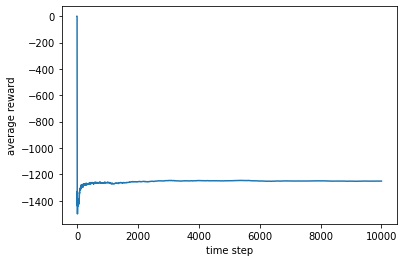

In [76]:
convergence_test(env, 10000, TBS, env, 5, 3)

Average reward: -1139.7871787178717


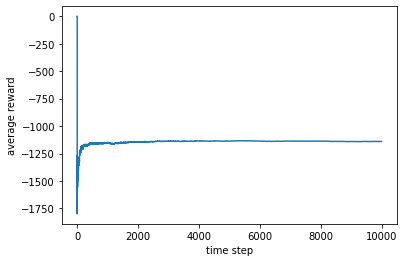

In [14]:
convergence_test(env, 10000, nn_policy, env)

In [15]:
# running_reward = 10
# live_time = []
episodes = 100
m = env.max_order + 1
for i_episode in range(episodes):
    state = env.reset()
    t = 0
    while True:
        state = np.asarray(state)
        action = select_action(state)
        state, reward, _, info = env.step(np.asarray([action // m, action % m]))
#         print(state)
        state = torch.from_numpy(state).float()
        reward = torch.tensor(reward).float()
#         if render: env.render()
        model.rewards.append(reward)
        
        if t >= 1000:
            break
        
        t = t + 1
    finish_episode()

Average reward: -1076.4861486148616


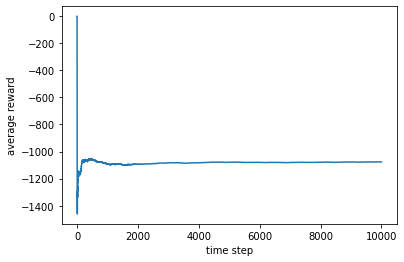

In [19]:
convergence_test(env, 10000, nn_policy, env)

In [20]:
evaluate(env, 50, 4000, nn_policy, env)

(-1069.0728100000001, 7.467461602941128)

with rewards normalization: -1100
w/o ......................: -1050
decision: remove

with smooth l1 loss: -1050
with l2 (mse) loss: -1108
with l1 loss: -1060
decision: undecided

equal weights for two losses: -1050
0.5 for value (critic) loss: -1050 ish
decision: maybe another hyper param to tune

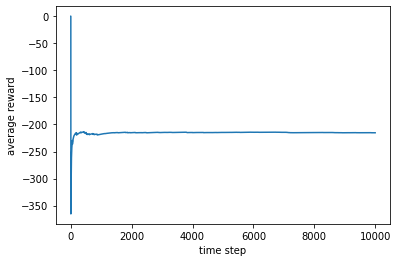

In [10]:
convergence_test(env, 10000, TBS, env, 2, 2)